# Introduction au Reservoir Computing et à ReservoirPy

Institut d'Optique - 08/01/2025

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

rpy.verbosity(0)
# Rendre tout déterministe
rpy.set_seed(2341)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Un exemple simple: Mackey-Glass

Les équations de Mackey-Glass décrivent un système chaotique.
https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations

#### Création de la série temporelle Mackey-Glass

In [2]:
from reservoirpy.datasets import mackey_glass

timeseries = mackey_glass(n_timesteps=2_000)
timeseries.shape

(2000, 1)

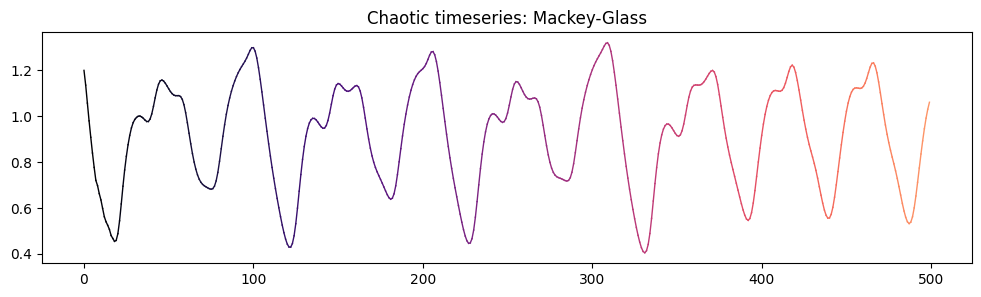

In [3]:
# Affichage
X = timeseries
timesteps = 500
plt.figure(figsize=(12, 3))
for i in range(timesteps-1):
    plt.plot([i, i+1], X[i:i+2, 0], color=plt.cm.magma(200*i//timesteps), lw=1.0)
plt.title("Chaotic timeseries: Mackey-Glass")
plt.show()

#### Prétraitement des données

On divise la série temporelle en entrées et sorties (X/Y), et en données d'entraînement et d'évaluation (train/test)

In [4]:
from reservoirpy.datasets import to_forecasting

# Prédiction à 10 pas de temps, 20% des données servent à l'évaluation
dataset = to_forecasting(X, forecast=10, test_size=0.2)
x_train, x_test, y_train, y_test = dataset

In [5]:
print(
    x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape,
)

(1590, 1) (400, 1) (1590, 1) (400, 1)


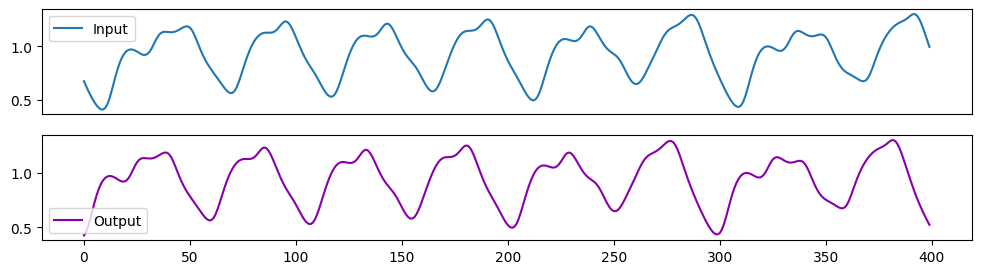

In [6]:
plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

#### Création du modèle

In [7]:
from reservoirpy.nodes import ESN

In [8]:
# Création en un seul noeud

model = ESN(
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
    ridge=1e-8) # Paramètre de régularisation

In [9]:
# Un réservoir connecté à la couche de sortie

reservoir = Reservoir(
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
)
readout = Ridge(ridge=1e-8) # Couche de régularisation
model = reservoir >> readout # Connection des nœuds

#### Entraînement et évaluation

In [10]:
model.fit(x_train, y_train) # Phase d'apprentissage
y_pred = model.run(x_test) # Phase de prédiction

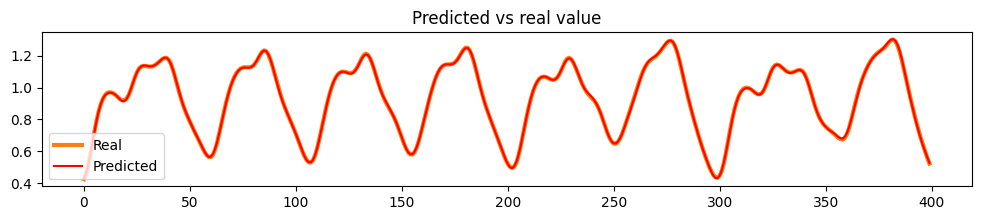

In [11]:
plt.figure(figsize=(12,2))
plt.plot(1)
plt.plot(y_test, label="Real", linewidth=3)
plt.plot(y_pred, label="Predicted", color="red")
plt.title("Predicted vs real value")
plt.legend()
plt.show()

### Quid d'une prédiction à $t+50$ ?

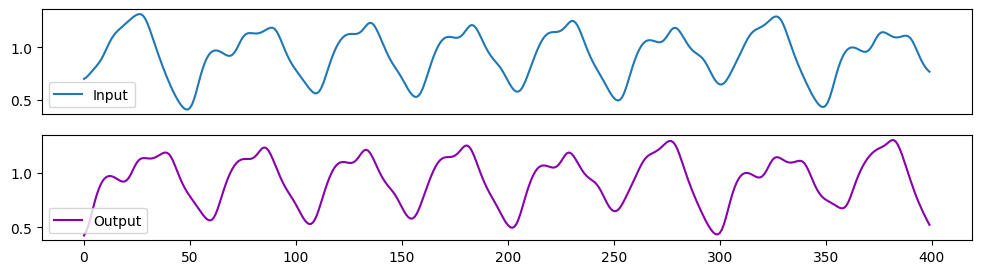

In [12]:
dataset = to_forecasting(X, forecast=50, test_size=0.2)  # prédiction à t+50
x_train, x_test, y_train, y_test = dataset

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(x_test, label="Input")
plt.legend()
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(y_test, label="Output", color="#8800AA")
plt.legend()
plt.show()

In [13]:
# Création du modèle

reservoir = Reservoir(units=100, lr=0.3, sr=1.25,)
readout = Ridge(ridge=1e-8) 
model = reservoir >> readout

# Entraînement
model.fit(x_train, y_train)
# Évaluation
y_pred = model.run(x_test)

In [14]:
def plot_figure(y_test, y_pred):
    plt.figure(figsize=(12,2))
    plt.plot(1)
    plt.plot(y_test, label="Real", linewidth=3)
    plt.plot(y_pred, label="Predicted", color="red")
    plt.title("Predicted vs real value")
    plt.legend()
    plt.show()

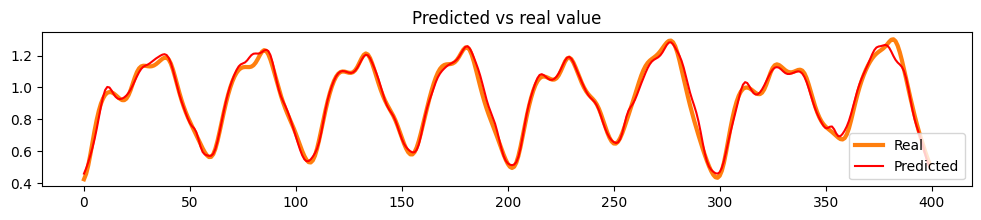

In [15]:
plot_figure(y_test, y_pred)

### Écoutons l'activité du réservoir...

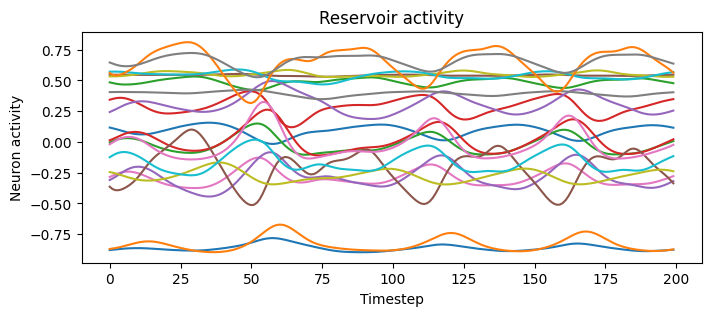

In [18]:
## !!! TODO : CORRIGER CETTE LIGNE 
activity = reservoir.run(x_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 pas de temps, 20 neurones visualisés
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

## Fonctionalité intéressantes : "seed" + parallélisation sur CPU 

### Contrôler la "seed" pour contrôler "l'aléatoire"

In [38]:
# On peut changer la seed génératrice d'aléatoire pour changer le poids initiaux des réservoirs 
rpy.set_seed(0) 
# -> vous n'êtes pas obligé de mettre 0, vous pouvez mettre le nombre que vous voulez.
# Ainsi vous pouvez tester l'influence de différentes seed avec les mêmes hyper-paramètres.

### Parallélisation sur CPU avec le noeud ESN

In [39]:
# Note importante :
# Lorsque vous utilisez le nœud/modèle ESN et que vous avez plusieurs séquences d'entrée,
# la parallélisation CPU sera effectuée en utilisant un cœur par séquence.
# (Ici, nous n'avons qu'une seule séquence, donc le comportement sera le même 
# que si vous définissiez vous-même "model = reservoir >> readout").
# Si vous souhaitez désactiver la parallélisation et n'utiliser qu'un seul cœur CPU,
# vous devez ajouter "workers=1" lors de l'initialisation du modèle ESN 
model = ESN( 
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=1.25, # rayon spectral de la matrice de poids
    ridge=1e-8, # paramètre de régularisation
    # workers=1, # utiliser un seul coeur CPU = pour désactiver la parallelisation CPU
    # workers=-1, # par défaut : la parallelisation est activée sur tous les coeurs CPU
)


# Ajustement du modèle
model.fit(x_train, y_train)

# Test du modèle
y_pred = model.run(x_test)

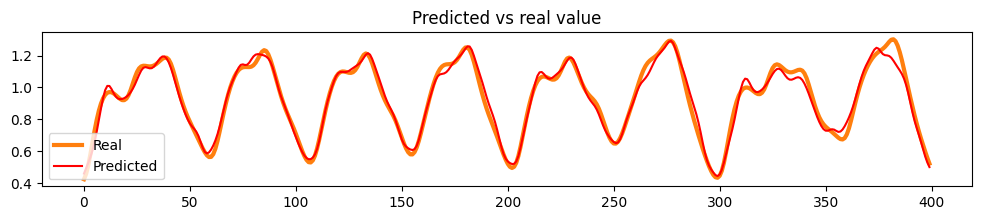

In [40]:
plot_figure(y_test, y_pred)

## A vous de jouer !

In [20]:
# A vous de jouer !
# Définissez et entrainez ci-dessous un modèle d'ESN en changeant les paramètres précédents

modelbis = ESN( 
    units=100, # neurones dans le réservoir
    lr=0.3, # taux de fuite
    sr=10, # rayon spectral de la matrice de poids
    ridge=1e-8, # paramètre de régularisation
)


# Ajustement du modèle
modelbis.fit(x_train, y_train)

# Test du modèle
y_pred = modelbis.run(x_test)


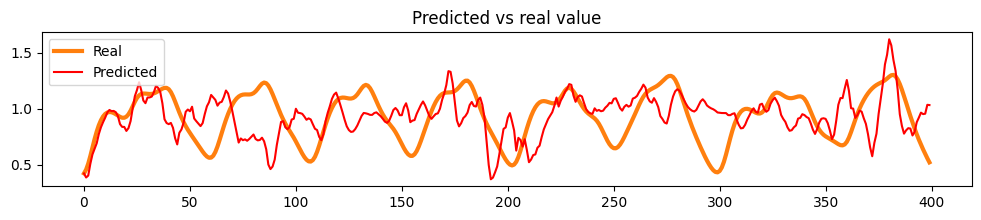

In [21]:
# Observez les changements sur les valeurs prédites
plot_figure(y_test, y_pred)

Observez les changements sur l'activité des neurones

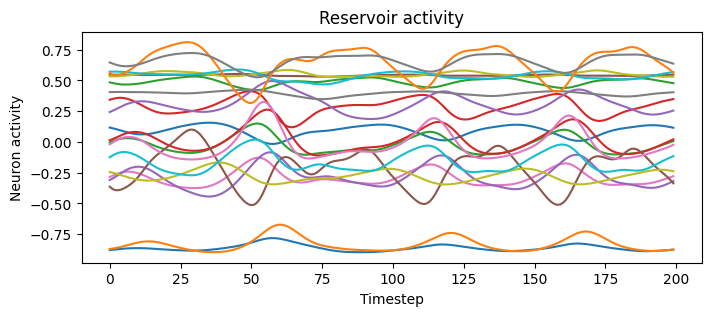

In [24]:
activity = reservoir.run(x_test)

plt.figure(figsize=(8, 3))
plt.plot(activity[:200, :20]) # 200 pas de temps, 20 neurones visualisés
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

#### Ah mais c'est étrange !
Cela ressemble exactement à l'activité que l'on avait avant ! Pourquoi ?
-> Car nous avons regardé l'activité du 1er reservoir que nous avions créé 
   et pas l'ESN que nous utilisons actuellement !

In [33]:
# Pour analyser l'activité d'un ESN il faut récupérer les activités d'une autre façon :
activitybis = modelbis.run(x_test,
    return_states=["reservoir"]) # On ajoute la liste des noeuds dont on veut récupérer l'activité.

# /!\ Attention, ce que l'on récupère lorsque l'on spécifie "return_states" est un dictionnaire.
print(activitybis)

# Il faut donc récupérer l'activité de la façon suivante:
## activitybis['reservoir']

{'reservoir': array([[-0.99951318,  0.99862913,  0.86969742, ...,  0.99090729,
         0.99995465,  0.99953305],
       [-0.99965923,  0.99904   ,  0.75188303, ...,  0.99363316,
         0.99996795,  0.99907841],
       [-0.99976146,  0.99932762,  0.61087059, ...,  0.99554181,
         0.99997704,  0.86182414],
       ...,
       [-0.96744104, -0.03334604,  0.89825405, ..., -0.83357127,
        -0.45955163, -0.9704059 ],
       [-0.97634478, -0.323341  ,  0.92874884, ..., -0.88349989,
        -0.60656752, -0.97928413],
       [-0.96882611, -0.52633859,  0.95003025, ..., -0.91844992,
        -0.41795876, -0.98549889]])}


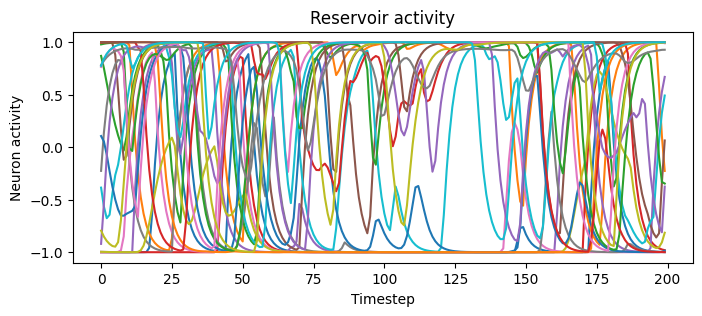

In [35]:
activitybis = modelbis.run(x_test,
    return_states=["reservoir"]) 

plt.figure(figsize=(8, 3))
plt.plot(activitybis['reservoir'][:200, :20]) # 200 pas de temps, 20 neurones visualisés
plt.title("Reservoir activity")
plt.xlabel("Timestep")
plt.ylabel("Neuron activity")
plt.show()

Et effectivement là on obtient bien un autre type d'activité !

# Annexes : comment utiliser d'autres fonctionalités de reservoirpy

In [30]:
# Tester l'utilisation de ces fonctionalités sur la tâche de prédiction précédente ou sur d'autres tâches (pour la classification notamment)

# ...

### Observables
Regardez comment utiliser des analyses avancées de reservoirpy avec les "observables" :
https://reservoirpy.readthedocs.io/en/latest/api/reservoirpy.observables.html

### Les connexions directes

In [23]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

model = reservoir >> readout

### Les connexions en feedback

In [24]:
reservoir = Reservoir(units=10)
readout = Ridge(ridge=1e-4)

reservoir <<= readout # create feedback
model = reservoir >> readout

### L'interface `scikit-learn`

In [25]:
from reservoirpy.nodes import ScikitLearnNode
from sklearn.linear_model import (
    RidgeClassifier, 
    LogisticRegression,
)
reservoir = Reservoir(units=10)

classifier = ScikitLearnNode(RidgeClassifier)
logistic_regressor = ScikitLearnNode(LogisticRegression)

model1 = reservoir >> classifier
model2 = reservoir >> logistic_regressor

### Créer son propre nœud

In [26]:
from reservoirpy import Node

def forward(node: Node, x: np.ndarray) -> np.ndarray:
    """Does something to the current state of the node, the input
    data and some feedback."""

    state = node.state()  # récupérer l'état du noeud
    some_param = node.const1
    some_other_param = node.const2
    if node.has_feedback:
        feedback = node.feedback()  # appeler l'état des noeuds en feedback
        return x + some_param * state + some_other_param * feedback
    else:
        return x + some_param * state

def initialize(node: Node, x: np.ndarray = None, y: np.ndarray = None):
    """This function receives a data point x at runtime and uses it to
    infer input and output dimensions.
    """
    if x is not None:
        node.set_input_dim(x.shape[1])
        node.set_output_dim(x.shape[1])
        node.set_param("const1", 1)

class CustomNode(Node):
    def __init__(self, const2=-1, name=None):
        super().__init__(
            forward=forward,
            initializer=initialize,
            params={"const1": None},
            hypers={"const2": const2},
            name=name,
        )

node = CustomNode(const2=-1, name="custom_node")

### Créer des architectures plus complexes

In [27]:
from reservoirpy.nodes import Input, Output

A, B, C, D, E, F = (Node() for _ in range(6))

path1, path2 = A >> F, B >> E
# Connexion un-vers-plusieurs, avec une liste
path3 = Input() >> [A, B, C]
# Chaîne de connexions
path4 = A >> B >> C >> D >> E >> F >> Output()
# Fusionner tous les modèles entre eux pour créer le graphe computationnel complet
model = path1 & path2 & path3 & path4